The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# LTI Systems

This chapter presents the theory of signals and systems, using musical acoustics as an example.
It explains an important application of the Convolution Theorem: characterization of linear, time-invariant systems (which I'll define soon).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/soln/chap10.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_corr

## Signals and Systems

In the context of signal processing, a **system** is an abstract representation of anything that takes a signal as input and produces a signal as output.

For example, an electronic amplifier is a circuit that takes an electrical signal as input and produces a (louder) signal as output.

As another example, when you listen to a musical performance, you can think of the room as a system that takes the sound of the performance at the location where it is generated and produces a somewhat different sound at the location where you hear it.

A **linear, time-invariant system** is a system with these two properties:

1.  Linearity: If you put two inputs into the system at the same time, the result is the sum of their outputs. Mathematically, if an input $x_1$ produces output $y_1$ and another input $x_2$ produces $y_2$, then $a x_1 + b x_2$ produces $a y_1 + b y_2$, where $a$ and $b$ are scalars.

2.  Time invariance: The effect of the system doesn't vary over time, or depend on the state of the system. So if inputs $x_1$ and $x_2$ differ by a shift in time, their outputs $y_1$ and $y_2$ differ by the same shift, but are otherwise identical.

Many physical systems have these properties, at least approximately.

-   Circuits that contain only resistors, capacitors and inductors are LTI, to the degree that the components behave like their idealized models.

-   Mechanical systems that contain springs, masses and dashpots are also LTI, assuming linear springs (force proportional to displacement) and dashpots (force proportional to velocity).

-   Also -- and most relevant to applications in this book -- the media that transmit sound (including air, water and solids) are well-modeled by LTI systems.

LTI systems are described by linear differential equations, and the solutions of those equations are complex sinusoids (see <http://en.wikipedia.org/wiki/Linear_differential_equation>).

This result provides an algorithm for computing the effect of an LTI system on an input signal:

1.  Express the signal as the sum of complex sinusoid components.

2.  For each input component, compute the corresponding output component.

3.  Add up the output components.

At this point, I hope this algorithm sounds familiar.
It's the same algorithm we used for convolution in Section xxx, and for differentiation in Section xxx.
This process is called **spectral decomposition** because we "decompose" the input signal into its spectral components.

In order to apply this process to an LTI system, we have to **characterize** the system by finding its effect on each component of the input signal.
For mechanical systems, it turns out that there is a simple and efficient way to do that: you kick it and record the output.

Technically, the "kick" is called an **impulse** and the output is called the **impulse response**.
You might wonder how a single impulse can completely characterize a system.
You can see the answer by computing the DFT of an impulse.
Here's a wave array with an impulse at $t=0$:

In [4]:
from thinkdsp import Wave

impulse = np.zeros(8)
impulse[0] = 1
impulse

array([1., 0., 0., 0., 0., 0., 0., 0.])

And here's its spectrum:

In [5]:
wave = Wave(impulse, framerate=8)
impulse_spectrum = wave.make_spectrum(full=True)
impulse_spectrum.hs

array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

The spectrum is all ones; that is, an impulse is the sum of components with equal magnitudes at all frequencies.
This spectrum should not be confused with white noise, which has the same *average* power at all frequencies, but varies around that average.

When you test a system by inputting an impulse, you are testing the response of the system at all frequencies.
And you can test them all at the same time because the system is linear, so simultaneous tests don't interfere with each other.


## Windows and Filters

To show why this kind of system characterization works, I will start with a simple example: a 2-element moving average.
We can think of this operation as a system that takes a signal as an input and produces a slightly smoother signal as an output.

In this example we know what the window is, so we can compute the corresponding filter.
But that's not usually the case; in the next section we'll look at an example where we don't know the window or the filter ahead of time.

Here's a window that computes a 2-element moving average (see Section [\[smoothing\]](#smoothing){reference-type="ref" reference="smoothing"}):

In [6]:
window_array = np.array([0.5, 0.5, 0, 0, 0, 0, 0, 0,])
window = Wave(window_array, framerate=8)

We can find the corresponding filter by computing the DFT of the window:

In [7]:
filtr = window.make_spectrum(full=True)

The following figure shows the result.
The filter that corresponds to a moving average window is a low-pass filter with the approximate shape of a Gaussian curve.

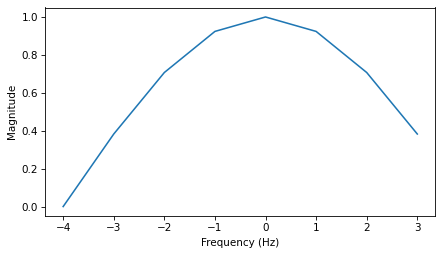

In [8]:
filtr.plot()
decorate_freq()

Now imagine that we did not know the window or the corresponding filter, and we wanted to characterize this system.
We would do that by inputting an impulse and measuring the impulse response.

In this example, we can compute the impulse response by multiplying the spectrum of the impulse and the filter, and then converting the result from a spectrum to a wave:

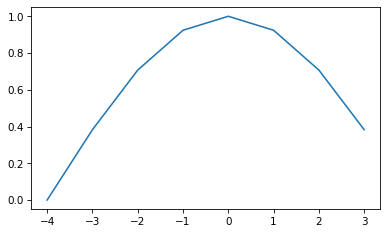

In [9]:
product = impulse_spectrum * filtr
product.plot()

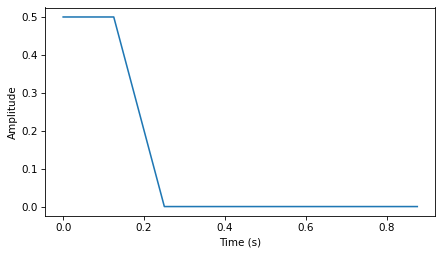

In [10]:
filtered = product.make_wave()
filtered.plot()
decorate_time()

Since `impulse_spectrum` is all ones, the product is identical to the filter, and the filtered wave is identical to the window.

This example demonstrates two things:

-   Because the spectrum of an impulse is all ones, the DFT of the impulse response is identical to the filter that characterizes the system.

-   Therefore, the impulse response is identical to the convolution window that characterizes the system.


## Acoustic Response

To characterize the acoustic response of a room or open space, a simple way to generate an impulse is to pop a balloon or fire a gun.
A gunshot puts an impulse into the system; the sound you hear is the impulse response.

As an example, I'll use a recording of a gunshot to characterize the room where the gun was fired, then use the impulse response to simulate the effect of that room on a violin recording.

This example is in `chap10.ipynb`, which is in the repository for this book; you can also view it, and listen to the examples, at <http://tinyurl.com/thinkdsp10>.

Here's the gunshot:

In [11]:
download('https://github.com/AllenDowney/ThinkDSP/raw/v2/soln/180960__kleeb__gunshot.wav')

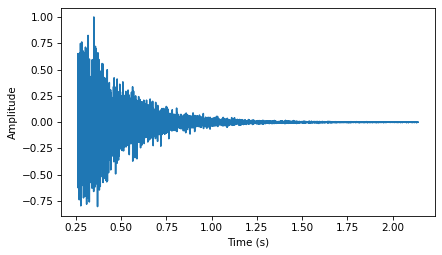

In [12]:
from thinkdsp import read_wave

response = read_wave('180960__kleeb__gunshot.wav')
response = response.segment(start=0.26, duration=5.0)
response.normalize()
response.plot()
decorate_time()

I selected a segment starting at 0.26 seconds to remove the silence before the gunshot.
The following figure shows the waveform of the gunshot.
Next we compute the DFT of `response`:

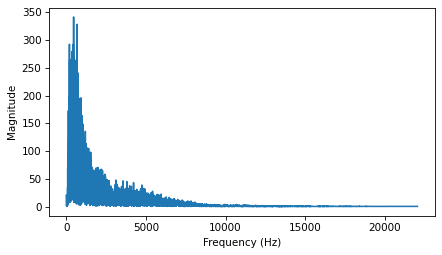

In [13]:
transfer = response.make_spectrum()
transfer.plot()
decorate_freq()

The following figure shows the result.
This spectrum encodes the response of the room; for each frequency, the spectrum contains a complex number that represents an amplitude multiplier and a phase shift.
This spectrum is called a **transfer function** because it contains information about how the system transfers the input to the output.

Now we can simulate the effect this room would have on the sound of a violin.
Here is the violin recording we used in Section [\[violin\]](#violin){reference-type="ref" reference="violin"}:

In [14]:
download('https://github.com/AllenDowney/ThinkDSP/raw/v2/soln/92002__jcveliz__violin-origional.wav')

In [15]:
violin = read_wave('92002__jcveliz__violin-origional.wav')
violin.truncate(len(response))
violin.normalize()

The violin and gunshot waves were sampled at the same framerate, 44,100 Hz. And coincidentally, the duration of both is about the same.
I trimmed the violin wave to the same length as the gunshot.

Next I compute the DFT of the violin wave:

In [16]:
spectrum = violin.make_spectrum()

Now I know the magnitude and phase of each component in the input, and I know the transfer function of the system.
Their product is the DFT of the output, which we can use to compute the output wave:

The following figure shows the input (top) and output (bottom) of the system.

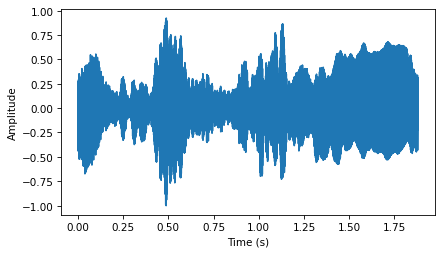

In [17]:
output = (spectrum * transfer).make_wave()
output.normalize()
output.plot()
decorate_time()

They are substantially different, and the differences are clearly audible.
Load `chap10.ipynb` and listen to them.
One thing I find striking about this example is that you can get a sense of what the room was like; to me, it sounds like a long, narrow room with hard floors and ceilings.
That is, like a firing range.

There's one thing I glossed over in this example that I'll mention in case it bothers anyone.
The violin recording I started with has already been transformed by one system: the room where it was recorded.
So what I really computed in my example is the sound of the violin after two transformations.
To properly simulate the sound of a violin in a different room, I should have characterized the room where the violin was recorded and applied the inverse of that transfer function first.


## Systems and Convolution

If you think the previous example is black magic, you are not alone.
I've been thinking about it for a while and it still makes my head hurt.

In the previous section, I suggested one way to think about it:

-   An impulse is made up of components with amplitude 1 at all frequencies.

-   The impulse response contains the sum of the responses of the system to all of these components.

-   The transfer function, which is the DFT of the impulse response, encodes the effect of the system on each frequency component in the form of an amplitude multiplier and a phase shift.

-   For any input, we can compute the response of the system by breaking the input into components, computing the response to each component, and adding them up.

But if you don't like that, there's another way to think about it altogether: convolution! By the Convolution Theorem, multiplication in the frequency domain corresponds to convolution in the time domain.
In this example, the output of the system is the convolution of the input and the system response.

Here are the keys to understanding why that works:

-   You can think of the samples in the input wave as a sequence of impulses with varying amplitude.

-   Each impulse in the input yields a copy of the impulse response, shifted in time (because the system is time-invariant) and scaled by the amplitude of the input.

-   The output is the sum of the shifted, scaled copies of the impulse response.
The copies add up because the system is linear.

Let's work our way up gradually: suppose that instead of firing one gun, we fire two: a big one with amplitude 1 at $t=0$ and a smaller one with amplitude 0.5 at $t=1$.

We can compute the response of the system by adding up the original impulse response and a scaled, shifted copy of itself.
Here's a function that makes a shifted, scaled copy of a wave:

In [18]:
def shifted_scaled(wave, shift, factor):
    """Make a shifted, scaled copy of a wave.
    
    wave: Wave
    shift: time shift, float
    factor: multiplier, float
    """
    res = wave.copy()
    res.shift(shift)
    res.scale(factor)
    return res

The parameter `shift` is a time shift in seconds; `factor` is a multiplicative factor.

Here's how we use it to compute the response to a two-gun salute:

In [19]:
shift = 1
factor = 0.5
gun2 = response + shifted_scaled(response, shift, factor)

The following figure shows the result.

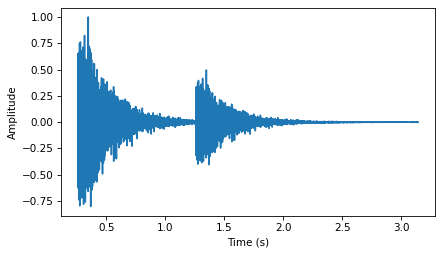

In [20]:
gun2.plot()
decorate_time()

You can hear what it sounds like in `chap10.ipynb`.

In [21]:
gun2.make_audio()

Not surprisingly, it sounds like two gunshots, the first one louder than the second.

Now suppose instead of two guns, you add up 100 guns fired at a rate of 441 shots per second.
This loop computes the result:

In [22]:
dt = 1 / 441
total = 0
for k in range(100):
    total += shifted_scaled(response, k*dt, 1.0)

With 441 shots per second, so you don't hear the individual shots.
Instead, it sounds like a periodic signal at 441 Hz. If you play this example, it sounds like a car horn in a garage.

In [23]:
total.normalize()
total.make_audio()

And that brings us to a key insight: you can think of any wave as a series of samples, where each sample is an impulse with a different amplitude.

As a example, I'll generate a sawtooth signal at 441 Hz:

In [24]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=441)
wave = signal.make_wave(duration=0.1,
                        framerate=response.framerate)

Now I'll loop through the series of impulses that make up the sawtooth, and add up the impulse responses:

In [25]:
total = 0
for t, y in zip(wave.ts, wave.ys):
    total += shifted_scaled(response, t, y)
total.normalize()

The result is what it would sound like to play a sawtooth wave in a firing range.
Again, you can listen to it in `chap10.ipynb`.

In [26]:
total.make_audio()

The following figure shows a diagram of this computation, where $f$ is the sawtooth, $g$ is the impulse response, and $h$ is the sum of the shifted, scaled copies of $g$.

In [27]:
#TODO: Insert diagram

For the example shown:

$$h[2] = f[0]g[2] + f[1]g[1] + f[2]g[0]$$

And more generally,

$$h[n] = \sum_{m=0}^{N-1} f[m] g[n-m]$$

You might recognize this equation from Section [\[convolution\]](#convolution){reference-type="ref" reference="convolution"}.
It is the convolution of $f$ and $g$.
This shows that if the input is $f$ and the impulse response of the system is $g$, the output is the convolution of $f$ and $g$.

In summary, there are two ways to think about the effect of a system on a signal:

1.  The input is a sequence of impulses, so the output is the sum of scaled, shifted copies of the impulse response; that sum is the convolution of the input and the impulse response.

2.  The DFT of the impulse response is a transfer function that encodes the effect of the system on each frequency component as a magnitude and phase offset.

The DFT of the input encodes the magnitude and phase offset of the frequency components it contains.
Multiplying the DFT of the input by the transfer function yields the DFT of the output.

The equivalence of these descriptions should not be a surprise; it is basically a statement of the Convolution Theorem: convolution of $f$ and $g$ in the time domain corresponds to multiplication in the frequency domain.
And if you wondered why convolution is defined as it is, which seemed backwards when we talked about smoothing and difference windows, now you know the reason: the definition of convolution appears naturally in the response of an LTI system to a signal.


## Proof of the Convolution Theorem

Well, I've put it off long enough.
It's time to prove the Convolution Theorem (CT), which states:

$$\DFT(f \conv g) = \DFT(f) \DFT(g)$$

where $f$ and $g$ are vectors with the same length, $N$.

I'll proceed in two steps:

1.  I'll show that in the special case where $f$ is a complex exponential, convolution with $g$ has the effect of multiplying $f$ by a scalar.

2.  In the more general case where $f$ is not a complex exponential, we can use the DFT to express it as a sum of exponential components, compute the convolution of each component (by multiplication) and then add up the results.

Together these steps prove the Convolution Theorem.
But first, let's assemble the pieces we'll need.
The DFT of $g$, which I'll call $G$ is:

$$DFT(g)[k] = G[k] = \sum_n g[n] \exp(-2 \pi i n k / N)$$

where $k$ is an index of frequency from 0 to $N-1$ and $n$ is an index of time from 0 to $N-1$.
The result is a vector of $N$ complex numbers.

The inverse DFT of $F$, which I'll call $f$, is:

$$IDFT(F)[n] = f[n] = \sum_k F[k] \exp(2 \pi i n k / N)$$

Here's the definition of convolution:

$$(f \conv g)[n] = \sum_m f[m] g[n-m]$$

where $m$ is another index of time from 0 to $N-1$.
Convolution is commutative, so I could equivalently write:

$$(f \conv g)[n] = \sum_m f[n-m] g[m]$$

Now let's consider the special case where $f$ is a complex exponential with frequency $k$, which I'll call $e_k$:

$$f[n] = e_k[n] = \exp(2 \pi i n k / N)$$

where $k$ is an index of frequency and $n$ is an index of time.

Plugging $e_k$ into the second definition of convolution yields:

$$(e_k \conv g)[n] = \sum_m \exp(2 \pi i (n-m) k / N) g[m]$$

We can split the first term into a product:

$$(e_k \conv g)[n] = \sum_m \exp(2 \pi i n k / N) \exp(-2 \pi i m k / N) g[m]$$

The first half does not depend on $m$, so we can pull it out of the summation:

$$(e_k \conv g)[n] = \exp(2 \pi i n k / N) \sum_m \exp(-2 \pi i m k / N) g[m]$$

Now we recognize that the first term is $e_k$, and the summation is $G[k]$ (using $m$ as the index of time).
So we can write:

$$(e_k \conv g)[n] = e_k[n] G[k]$$

which shows that for each complex exponential, $e_k$, convolution with $g$ has the effect of multiplying $e_k$ by $G[k]$.
In mathematical terms, each $e_k$ is an eigenvector of this operation, and $G[k]$ is the corresponding eigenvalue (see Section [\[effdiff\]](#effdiff){reference-type="ref" reference="effdiff"}).

Now for the second part of the proof.
If the input signal, $f$, doesn't happen to be a complex exponential, we can express it as a sum of complex exponentials by computing its DFT, $F$.
For each value of $k$ from 0 to $N-1$, $F[k]$ is the complex magnitude of the component with frequency $k$.

Each input component is a complex exponential with magnitude $F[k]$, so each output component is a complex exponential with magnitude $F[k] G[k]$, based on the first part of the proof.

Because the system is linear, the output is just the sum of the output components:

$$(f \conv g)[n] = \sum_k F[k] G[k] e_k[n]$$

Plugging in the definition of $e_k$ yields:

$$(f \conv g)[n] = \sum_k F[k] G[k] \exp(2 \pi i n k / N)$$

The right hand side is the inverse DFT of the product $F G$. Thus:

$$(f \conv g) = \IDFT( F G )$$

Substituting $F = \DFT(f)$ and $G = \DFT(g)$:

$$(f \conv g) = \IDFT( \DFT(f) \DFT(g) )$$

Finally, taking the DFT of both sides yields the Convolution Theorem:

$$\DFT(f \conv g) = \DFT(f) \DFT(g)$$

QED

## Exercises

### Exercise 10.1

In this chapter I describe convolution as the sum of shifted, scaled copies of a signal.
Strictly speaking, this operation is *linear* convolution, which does not assume that the signal is periodic.

But when we multiply the DFT of the signal by the transfer function, that operation corresponds to *circular* convolution, which assumes that the signal is periodic.
As a result, you might notice that the output contains an extra note at the beginning, which wraps around from the end.

Fortunately, there is a standard solution to this problem.
If you add enough zeros to the end of the signal before computing the DFT, you can avoid wrap-around and compute a linear convolution.

Modify the example in `chap10soln.ipynb` and confirm that zero-padding eliminates the extra note at the beginning of the output.


I'll truncate both signals to $2^{16}$ elements, then zero-pad them to $2^{17}$.
Using powers of two makes the FFT algorithm most efficient.

Here's the impulse response:

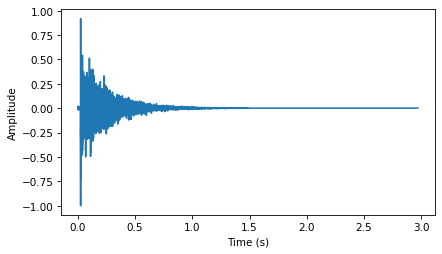

In [28]:
from thinkdsp import read_wave

response = read_wave('180960__kleeb__gunshot.wav')

start = 0.12
response = response.segment(start=start)
response.shift(-start)

response.truncate(2**16)
response.zero_pad(2**17)

response.normalize()
response.plot()
decorate_time()

And its spectrum:

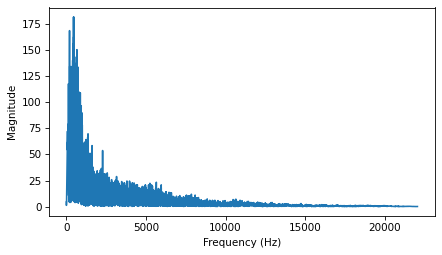

In [29]:
transfer = response.make_spectrum()
transfer.plot()
decorate_freq()

Here's the signal:

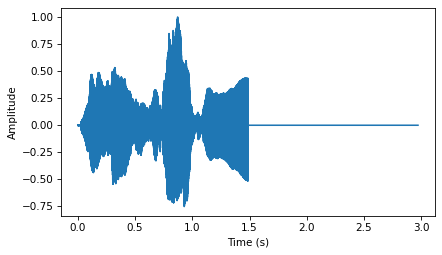

In [30]:
violin = read_wave('92002__jcveliz__violin-origional.wav')

start = 0.11
violin = violin.segment(start=start)
violin.shift(-start)

violin.truncate(2**16)
violin.zero_pad(2**17)

violin.normalize()
violin.plot()
decorate_time()

And its spectrum:

In [31]:
spectrum = violin.make_spectrum()

Now we can multiply the DFT of the signal by the transfer function, and convert back to a wave:

In [32]:
output = (spectrum * transfer).make_wave()
output.normalize()

The result doesn't look like it wraps around:

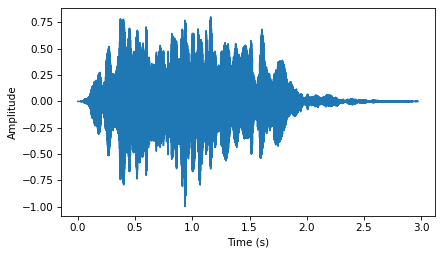

In [33]:
output.plot()
decorate_time()

And we don't hear the extra note at the beginning:

In [34]:
output.make_audio()

We should get the same results from `np.convolve` and `scipy.signal.fftconvolve`.

First I'll get rid of the zero padding:

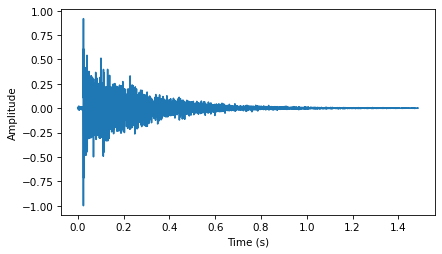

In [35]:
response.truncate(2**16)
response.plot()
decorate_time()

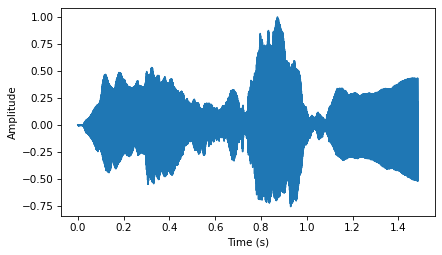

In [36]:
violin.truncate(2**16)
violin.plot()
decorate_time()

Now we can compare to `np.convolve`:

In [37]:
output2 = violin.convolve(response)

The results are similar:

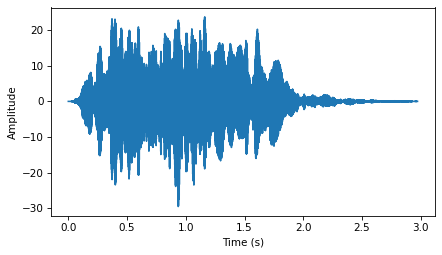

In [38]:
output2.plot()
decorate_time()

And sound the same:

In [39]:
output2.make_audio()

But the results are not exactly the same length:

In [40]:
len(output), len(output2)

(131072, 131071)

`scipy.signal.fftconvolve` does the same thing, but as the name suggests, it uses the FFT, so it is substantially faster:

In [41]:
from thinkdsp import Wave
import scipy.signal

ys = scipy.signal.fftconvolve(violin.ys, response.ys)
output3 = Wave(ys, framerate=violin.framerate)

The results look the same.

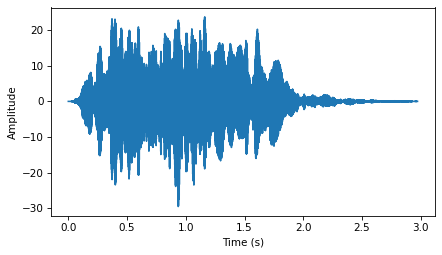

In [42]:
output3.plot()
decorate_time()

And sound the same:

In [43]:
output3.make_audio()

And within floating point error, they are the same:

In [44]:
output2.max_diff(output3)

1.9539925233402755e-14

### Exercise 10.2  

The Open AIR library provides a "centralized... on-line resource for anyone interested in auralization and acoustical impulse response data" (http://www.openairlib.net).
Browse their collection of impulse response data and download one that sounds interesting.
Find a short recording that has the same sample rate as the impulse response you downloaded.

Simulate the sound of your recording in the space where the impulse response was measured, computed two way: by convolving the recording with the impulse response and by computing the filter that corresponds to the impulse response and multiplying by the DFT of the recording.


I downloaded the impulse response of the Lady Chapel at St Albans Cathedral http://www.openairlib.net/auralizationdb/content/lady-chapel-st-albans-cathedral

Thanks to Audiolab, University of York: Marcin Gorzel, Gavin Kearney, Aglaia Foteinou, Sorrel Hoare, Simon Shelley.

In [45]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/stalbans_a_mono.wav')

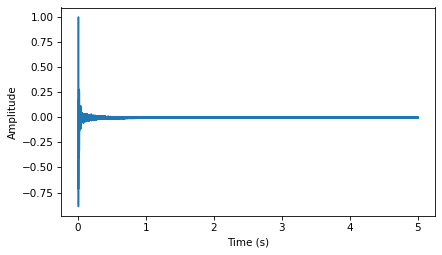

In [46]:
response = read_wave('stalbans_a_mono.wav')

start = 0
duration = 5
response = response.segment(duration=duration)
response.shift(-start)

response.normalize()
response.plot()
decorate_time()

Here's what it sounds like:

In [47]:
response.make_audio()

The DFT of the impulse response is the transfer function:

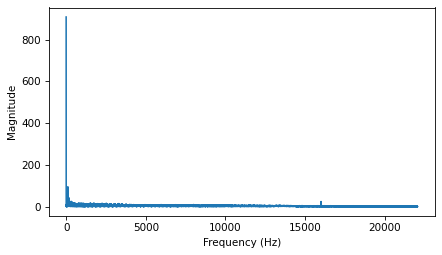

In [48]:
transfer = response.make_spectrum()
transfer.plot()
decorate_freq()

Here's the transfer function on a log-log scale:

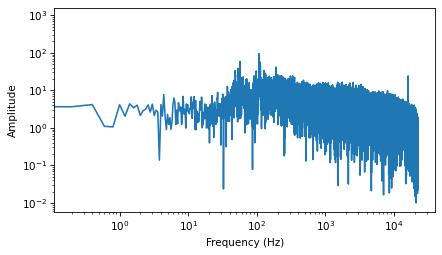

In [49]:
transfer.plot()
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude',
         xscale='log', yscale='log')

Now we can simulate what a recording would sound like if it were played in the same room and recorded in the same way.
Here's the trumpet recording we have used before:

In [50]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/170255__dublie__trumpet.wav')

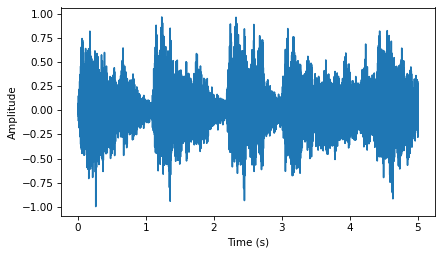

In [51]:
wave = read_wave('170255__dublie__trumpet.wav')

start = 0.0
wave = wave.segment(start=start)
wave.shift(-start)

wave.truncate(len(response))
wave.normalize()
wave.plot()
decorate_time()

Here's what it sounds like before transformation:

In [52]:
wave.make_audio()

Now we compute the DFT of the trumpet recording.

In [53]:
spectrum = wave.make_spectrum()

I trimmed the trumpet recording to the same length as the impulse response:

In [54]:
len(spectrum.hs), len(transfer.hs)

(110251, 110251)

In [55]:
spectrum.fs[:10]

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])

In [56]:
transfer.fs[:10]

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])

Now we can multiply in the frequency domain and the transform back to the time domain.

In [57]:
output = (spectrum * transfer).make_wave()
output.normalize()

Here's a  comparison of the original and transformed recordings:

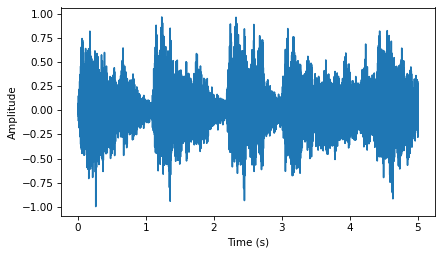

In [58]:
wave.plot()
decorate_time()

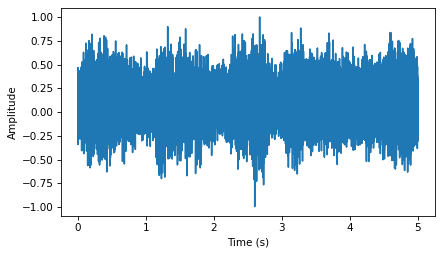

In [59]:
output.plot()
decorate_time()

And here's what it sounds like:

In [60]:
output.make_audio()

Now that we recognize this operation as convolution, we can compute it using the convolve method:

In [61]:
convolved2 = wave.convolve(response)
convolved2.normalize()
convolved2.make_audio()

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)